In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import optuna
from joblib import dump

In [120]:
core_path = '/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/phenotyping/xgboost/standard/'

In [121]:
data = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/phenotyping/manual_phenotypes_standard.csv')

In [122]:
data.drop(columns=["index", "Y_centroid", "X_centroid"], inplace=True)

In [123]:
transformed = np.arcsinh(data.iloc[:, 0:32, ])
data.drop(columns=data.columns[0:32], inplace=True)
phenotypes = pd.concat([transformed, data], axis=1)

In [124]:
phenotypes

,CD38,Perilipin,Vimentin,B4GALT1,MPO,CathepsinK,ATP5A,RUNX2,HIF1A,CD11b,...,CPT1A,HLA-DR,ST6GAL1,CD138,area,axis_major_length,axis_minor_length,eccentricity,distance_to_bone,phenotype
0,3.609161,1.372057,3.848555,2.666951,0.239946,0.740500,3.576348,0.359609,0.701710,2.141337,...,3.367454,2.126994,1.755674,4.909530,20,9.015001,2.801743,0.950480,949.830511,Plasma Cells/MM cells
1,3.630292,1.580074,3.304330,2.221222,0.110884,0.383782,3.459937,0.460752,0.863042,1.790710,...,3.127464,2.230719,1.477988,5.058997,9,3.781743,3.130045,0.561211,935.523917,Plasma Cells/MM cells
2,3.463597,1.003922,3.589288,2.505620,0.220433,0.770115,3.571145,0.327450,1.313211,1.771079,...,3.327885,2.086925,2.012978,4.524750,9,4.618802,2.739740,0.805076,928.347457,Plasma Cells/MM cells
3,4.281420,2.522427,4.447547,2.860062,0.000000,1.777456,4.307119,0.438505,3.190661,2.613537,...,3.766461,2.871604,2.660180,4.610950,5,4.093338,1.563516,0.924176,887.244048,CD8+Tcells
4,3.301451,0.807130,3.992217,2.288206,0.375988,0.875580,3.503845,0.709510,2.651201,1.913717,...,3.217072,2.435502,1.397982,3.715451,16,6.222716,3.263864,0.851406,809.068600,Endothelial cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103635,1.626053,1.397445,3.347295,2.273977,1.850444,0.697298,2.661427,0.688247,3.418221,3.486295,...,2.706866,1.904723,1.645497,0.076847,13,7.554372,1.975318,0.965209,219.965906,Macrophages/Monocytes
103636,0.804938,0.648296,1.443068,1.638616,0.893867,0.126242,3.004572,0.279079,2.456068,2.265614,...,2.978468,1.316105,1.400559,0.099834,20,6.257452,4.099304,0.755536,213.546248,Unknown
103637,1.149305,0.334513,1.707183,1.915488,2.276541,0.116964,2.396891,0.084881,0.643683,1.438106,...,1.925200,2.343874,2.224051,0.192442,24,6.490504,5.119248,0.614741,0.000000,Endothelial cells
103638,1.760658,0.642901,3.175161,2.094225,1.138999,0.851238,2.971767,0.386202,3.918418,3.214858,...,3.055611,1.423217,1.143904,0.419954,11,6.410748,1.964940,0.951868,334.092801,Macrophages/Monocytes


In [125]:
phenotypes['distance_to_bone'] = phenotypes['distance_to_bone'].replace(-999, np.nan)

In [126]:
X = phenotypes.iloc[:, :-1]
y = phenotypes.iloc[:, -1]

In [127]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [128]:
label_mapping = pd.DataFrame({
    'Phenotype': y,
    'EncodedLabel': y_encoded
})

label_mapping.drop_duplicates(inplace=True)

label_mapping.to_csv(core_path + '/phenotype_label_mapping.csv', index=False)

In [129]:
classes = np.unique(y_encoded)
weights = compute_class_weight('balanced', classes=classes, y=y_encoded)
class_weights = dict(zip(classes, weights))

In [130]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.10, random_state=20240610)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=20240610)

In [131]:
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20240610)

In [132]:
model = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    use_label_encoder=False,
    num_class=len(np.unique(y_encoded))
)

In [133]:
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [300, 400, 500, 600, 700, 800],
    'lambda': [0.2, 0.5, 1, 1.5, 2],
    'alpha': [0, 0.5, 1, 2]
}

In [134]:
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, scoring='f1_weighted', cv=stratified_kfold, verbose=2, random_state=20240610, n_jobs=-1)

In [135]:
sample_weights = np.array([class_weights[class_label] for class_label in y_train])

In [136]:
random_search.fit(X_train, y_train, sample_weight=sample_weights)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END alpha=1, colsample_bytree=0.7, gamma=0.2, lambda=1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=700, subsample=0.7; total time= 2.9min
[CV] END alpha=1, colsample_bytree=0.7, gamma=0.2, lambda=1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=700, subsample=0.7; total time= 2.9min
[CV] END alpha=1, colsample_bytree=0.7, gamma=0.2, lambda=1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=700, subsample=0.7; total time= 2.9min
[CV] END alpha=1, colsample_bytree=0.7, gamma=0.2, lambda=1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=700, subsample=0.7; total time= 2.9min
[CV] END alpha=1, colsample_bytree=0.7, gamma=0.2, lambda=1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=700, subsample=0.7; total time= 2.9min
[CV] END alpha=1, colsample_bytree=0.7, gamma=0.2, lambda=1, learning_rate=0.05, max_depth=6, min_child_w

KeyboardInterrupt: 

In [ ]:
best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)
with open(core_path + '/best_model_params.txt', 'w') as file:
    file.write("Best Model Parameters:\n")
    for param, value in random_search.best_params_.items():
        file.write(f"{param}: {value}\n")

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.8743085037951884
F1 Score (weighted): 0.8748693017989906
                                 precision    recall  f1-score   support

                     Adipocytes       0.78      0.92      0.84       324
                     CD3+Tcells       0.75      0.75      0.75       419
                     CD4+Tcells       0.90      0.91      0.90       741
                          CD45+       0.81      0.84      0.83      1198
                     CD8+Tcells       0.91      0.92      0.92      1354
                Dendritic Cells       0.76      0.77      0.76       302
              Endothelial cells       0.73      0.73      0.73       535
                           HSCs       0.72      0.69      0.70       452
          Macrophages/Monocytes       0.81      0.85      0.83       750
            Myeloid/Neutrophils       0.85      0.87      0.86      2017
                    Osteoblasts       0.83      0.82      0.83       134
                    Osteoclasts       0.73      0.96  

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_20027/2919046767.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Features', data=importance_df, palette='viridis')


Text(0.5, 1.0, 'Feature Importances Visualized')

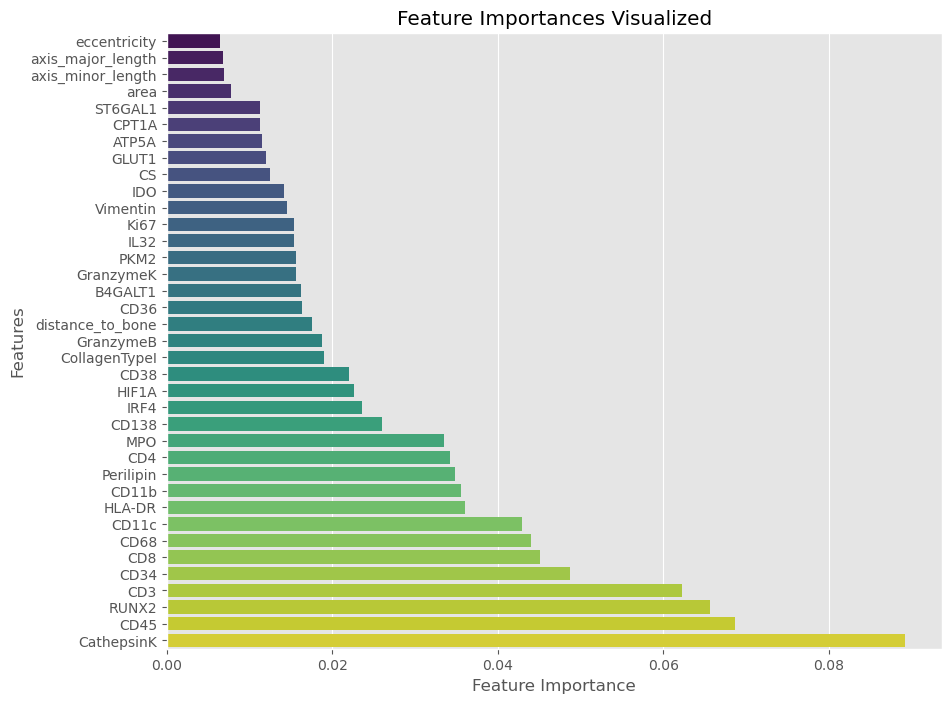

In [ ]:
plt.style.use('ggplot')

feature_importances = best_model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'Features': features,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=True)


plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Features', data=importance_df, palette='viridis')

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances Visualized')
plt.savefig(core_path + 'feature_importances.png', dpi=300)

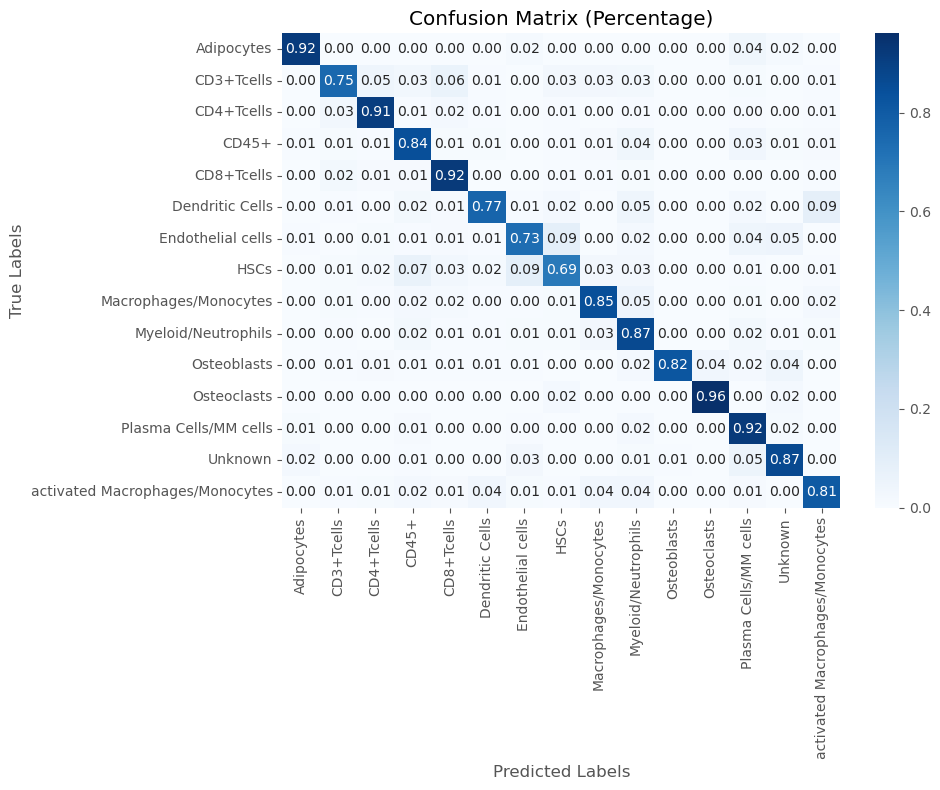

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Calculate the percentage of each value in the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentage)')
plt.tight_layout()
plt.savefig(core_path + 'confusion_matrix_percentage.png', dpi=300)
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Convert the classification report into DataFrame
report_df = pd.DataFrame(report).transpose()
report_df = report_df[report_df.index != 'accuracy']
accuracies = {}
for label_str in label_encoder.classes_:
    label_int = label_encoder.transform([label_str])[0]
    mask = y_test == label_int
    if mask.sum() > 0:
        accuracies[label_str] = accuracy_score(y_test[mask], y_pred[mask])
    else:
        accuracies[label_str] = np.nan

# Add the accuracies to the classification report DataFrame
report_df['accuracy'] = pd.Series(accuracies)

# Calculate macro average accuracy
macro_avg_accuracy = report_df.loc[label_encoder.classes_, 'accuracy'].mean()

# Calculate weighted average accuracy
weights = report_df.loc[label_encoder.classes_, 'support'] / report_df.loc[label_encoder.classes_, 'support'].sum()
weighted_avg_accuracy = np.sum(report_df.loc[label_encoder.classes_, 'accuracy'] * weights)

# Add the macro average and weighted average to the classification report DataFrame
report_df.loc['macro avg', 'accuracy'] = macro_avg_accuracy
report_df.loc['weighted avg', 'accuracy'] = weighted_avg_accuracy
report_df = report_df[['precision', 'recall', 'f1-score', 'accuracy', 'support']]

In [ ]:
report_df.to_csv(core_path + 'classification_report_wb.csv', index=True)

In [ ]:
dump(best_model, core_path + 'best_xgb_model_wb.joblib')

['/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/phenotyping/xgboost/standard/best_xgb_model_wb.joblib']